In [1]:
"""
STATE: PA
POLICY: Decriminalizing marijuana
VERSION: V1
DATA SOURCE: USSC https://github.com/khwilson/SentencingCommissionDatasets
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: Total population per month
REFERENCE_DATE: September 2020
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

In [2]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [3]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [4]:
# PA_DIRECTORY_PATH = "recidiviz/calculator/modeling/population_projection/state/PA/"

# Get the simulation tag from the model inputs config
yaml_file_path = "pa_mj_decrim_model_inputs_baseline.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

In [5]:
# setting values from queries
end_date_for_sentencing_comm_data = "2019-12-31"
end_date_for_recent_arrest_data = "2022-09-01"

In [6]:
class Sanction:
    def __init__(self, dic):
        self.name = dic["name"]
        self.start_date = dic["start_date"]
        self.end_date = dic["end_date"]
        self.los = dic["los"]

In [7]:
PRISON = Sanction(
    {
        "name": "PRISON",
        "start_date": "INC_START",
        "end_date": "INC_END",
        "los": "INCMAX",
    }
)

In [8]:
JAILMIN = Sanction(
    {"name": "JAIL", "start_date": "INC_START", "end_date": "INC_END", "los": "JMIN"}
)

In [9]:
JAILMAX = Sanction(
    {"name": "JAIL", "start_date": "INC_START", "end_date": "INC_END", "los": "JMAX"}
)

In [10]:
PROBATION = Sanction(
    {
        "name": "PROB",
        "start_date": "PROB_START",
        "end_date": "PROB_END",
        "los": "PROMIN",
    }
)

## Setup arrest data

#### Read data from Jan 2017-Oct 2022

In [11]:
# read in UCR PA Adult Arrest Report csvs from Jan 2016-Oct 2022
years = np.arange(2017, 2023)
pa_mj_arrests = pd.concat(
    [
        pd.read_csv(
            f"pa_mj_arrests/{year}_PA_SRS_AnnualSummary_AdultArres.csv", thousands=","
        )
        for year in years
    ],
    keys=years,
)

# clean up df
pa_mj_arrests = (
    pa_mj_arrests.dropna(axis=1, how="all")
    .reset_index(level=0)
    .rename(columns={"level_0": "Year", "Classification of Offenses": "Offense"})
)
pa_mj_arrests["Offense"].fillna(method="ffill", inplace=True)

# sum up over male/female
pa_mj_arrest_data = (
    pa_mj_arrests.groupby(["Offense", "Year"])
    .agg({"Total": "sum"})
    .unstack(level=0)["Total"]
)[
    [
        "Drug Abuse Violations - Grand Total",
        "(1) Sale/Manufacturing - Subtotal",
        "18b - Marijuana",
        "(2) Possession - Subtotal",
        "18f - Marijuana",
    ]
]

# rename relevant columns
pa_mj_arrest_data = pa_mj_arrest_data.set_axis(
    ["all_drug", "all_sale", "mj_sale", "all_poss", "mj_poss"], axis=1
)

# sum up total marijuana arrests
pa_mj_arrest_data["mj_total_arrests"] = (
    pa_mj_arrest_data.mj_sale + pa_mj_arrest_data.mj_poss
)

# calc arrests per month (approximating 2022 as 9 months)
pa_mj_arrest_data["num_months"] = [9 if year == 2022 else 12 for year in years]
pa_mj_arrest_data["avg_arrests_per_month"] = (
    pa_mj_arrest_data.mj_total_arrests / pa_mj_arrest_data.num_months
)

In [12]:
pa_mj_arrest_data.index = pd.to_datetime(pa_mj_arrest_data.index, format="%Y")
monthly_pa_mj_arrest_data = pa_mj_arrest_data.reindex(
    pd.date_range(
        start=pa_mj_arrest_data.index[0], end=end_date_for_recent_arrest_data, freq="MS"
    ),
    method="ffill",
)[["mj_total_arrests", "num_months", "avg_arrests_per_month"]]

In [13]:
pa_mj_arrest_data

,all_drug,all_sale,mj_sale,all_poss,mj_poss,mj_total_arrests,num_months,avg_arrests_per_month
Year,,,,,,,,
2017-01-01,60870,17231,4466,43639,21036,25502,12,2125.166667
2018-01-01,60076,15883,3912,44221,22058,25970,12,2164.166667
2019-01-01,58007,15015,3454,42992,20777,24231,12,2019.250000
2020-01-01,47820,11029,2849,36794,19199,22048,12,1837.333333
2021-01-01,39118,10573,2067,28546,12434,14501,12,1208.416667
2022-01-01,23102,6788,1278,16314,7415,8693,9,965.888889


### Set up prison/parole transition flows table

In [14]:
inc_outcomes = pd.read_gbq(
    f"""
        SELECT
            sen.person_id,
            CASE
              WHEN outflow_to_level_1 = 'LIBERTY'
                THEN 'prison_to_liberty'
              WHEN outflow_to_level_2 = 'PAROLE'
                THEN 'prison_to_parole'
            END as outcome,
            session_length_days / max_sentence_length_days_calculated as percent_stay,
        FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
        JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
            ON ses.person_id = sen.person_id 
            AND ses.start_date BETWEEN sen.effective_date AND COALESCE(sen.completion_date, '9999-01-01')
        WHERE ses.state_code = 'US_PA'
            AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
            AND ses.compartment_level_1 = 'INCARCERATION'
            AND (outflow_to_level_1 = 'LIBERTY' OR outflow_to_level_2 = 'PAROLE')
            AND offense_type = "DRUGS"
        QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id ORDER BY max_sentence_length_days_calculated DESC) = 1
    """,
    project_id="recidiviz-staging",
)

In [15]:
parole_percent_stay = pd.read_gbq(
    f"""
        WITH percent_stays as (
            SELECT
                sen.person_id,
                session_length_days / max_sentence_length_days_calculated as percent_stay
            FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
            JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
                ON ses.person_id = sen.person_id 
                AND ses.start_date BETWEEN sen.effective_date AND sen.completion_date
            WHERE ses.state_code = 'US_PA'
                AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
                AND ses.inflow_from_level_1 = 'INCARCERATION'
                AND ses.compartment_level_2 = 'PAROLE'
                AND outflow_to_level_1 = 'LIBERTY'
                AND offense_type = "DRUGS"
            QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id ORDER BY sen.min_sentence_length_days_calculated DESC) = 1
        )
        SELECT
            avg(percent_stay) as avg_percent_stay
        FROM percent_stays
    """,
    project_id="recidiviz-staging",
)

In [16]:
# calculate percent of prisoners released to parole vs. liberty
parole_frac = (
    inc_outcomes.groupby("outcome").count()[["person_id"]] / inc_outcomes.shape[0]
)

# Calculate average parole stay, as a percent of prison LOS
percent_stays = inc_outcomes.groupby("outcome").percent_stay.mean()

# Create table to calculate prison/parole outflows and LOS
prison_flows = pd.concat([parole_frac, percent_stays], axis=1).rename(
    columns={"person_id": "percent_outflow"}
)
prison_flows["start_date_multiplier"] = 0

prison_flows.loc["parole_to_liberty"] = {
    "percent_outflow": prison_flows.loc["prison_to_parole", "percent_outflow"],
    "start_date_multiplier": prison_flows.loc["prison_to_parole", "percent_stay"],
    "percent_stay": parole_percent_stay.avg_percent_stay[0]
    + prison_flows.loc["prison_to_parole", "percent_stay"],
}

# Manual inputs for probation and jail flows
prison_flows.loc["probation_to_liberty"] = {
    "percent_outflow": 1,
    "start_date_multiplier": 0,
    "percent_stay": 1,
}

prison_flows.loc["jail_to_liberty"] = {
    "percent_outflow": 1,
    "start_date_multiplier": 0,
    "percent_stay": 1,
}
prison_flows.reset_index(inplace=True)
prison_flows[["compartment", "outflow_to"]] = prison_flows.outcome.str.split(
    "_to_", expand=True
)

# on merge with sentences, each prison sentence will be mapped to 3 outflow rows:
# prison->parole, prison->liberty, parole->liberty
prison_flows["compartment_for_merge"] = [
    "prison",
    "prison",
    "prison",
    "probation",
    "jail",
]

prison_flows = prison_flows.rename(columns={"percent_stay": "end_date_multiplier"})
prison_flows

,outcome,percent_outflow,end_date_multiplier,start_date_multiplier,compartment,outflow_to,compartment_for_merge
0,prison_to_liberty,0.164538,0.397732,0.000000,prison,liberty,prison
1,prison_to_parole,0.835462,0.276759,0.000000,prison,parole,prison
2,parole_to_liberty,0.835462,0.770405,0.276759,parole,liberty,prison
3,probation_to_liberty,1.000000,1.000000,0.000000,probation,liberty,probation
4,jail_to_liberty,1.000000,1.000000,0.000000,jail,liberty,jail


### Set up eligible sentences table

In [17]:
def query_all_sentences(sanction: Sanction) -> pd.DataFrame:
    return pd.read_gbq(
        f"""
          SELECT
            CONCAT(OFF_FNAME,OFF_LNAME,OFF_RACE,OFF_SEX,IFNULL(SAFE.PARSE_DATE('%F', SPLIT(DOB,' ')[OFFSET(0)]),"1111-11-11")) AS ID,
            SAFE.PARSE_DATE('%F', SPLIT(DOS,' ')[OFFSET(0)]) dos,
            REGEXP_CONTAINS(DRUG,r'(?i)marij') is_mj_offense,
            CASE 
              WHEN off_race = 'White' THEN 'white'
              WHEN off_race = 'Black' THEN 'Black'
              ELSE 'other'
            END as race,
            REGEXP_CONTAINS(ofn_label, r'(?i)(deliv)') as is_mj_sale,
            ogs as gravity_score,
            CASE
              WHEN MS_SANCTION LIKE CONCAT('%1%')
                THEN 'prison'
              WHEN MS_SANCTION LIKE CONCAT('%3%')
                THEN 'jail'
              WHEN MS_SANCTION LIKE CONCAT('%5%')
                THEN 'probation'
            END as sentence_compartment,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.start_date},' ')[OFFSET(0)]) start_date,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.end_date},' ')[OFFSET(0)]) end_date,
            SAFE_CAST({sanction.los} AS FLOAT64) los,
          FROM `recidiviz-staging.spark_public_input_data.us_pa_charge_data` pa
          WHERE {sanction.name} = '1.0'
        """,
        project_id="recidiviz-staging",
    )

In [18]:
prisonsen = query_all_sentences(PRISON)

In [19]:
jailsen = query_all_sentences(JAILMIN)

In [20]:
probationsen = query_all_sentences(PROBATION)

In [21]:
allsen = pd.concat([prisonsen, jailsen, probationsen])

In [22]:
# get all sentencing groups by dos (date of sentence) where at least one is MJ
mj_sentence_groups = allsen.groupby(["ID", "dos", "sentence_compartment"]).filter(
    lambda x: x.is_mj_offense.any()
)
# calculate if the sentence group is only MJ or if there are also non-MJ sentences
mj_sentence_groups["any_mj"] = mj_sentence_groups.groupby(
    ["ID", "dos", "sentence_compartment"]
).is_mj_offense.transform("any")
mj_sentence_groups["all_mj"] = mj_sentence_groups.groupby(
    ["ID", "dos", "sentence_compartment"]
).is_mj_offense.transform("all")
# classify each as 'only' first or if not, then 'any' (aka there are non-MJ sentences too)
mj_sentence_groups["crime_type"] = mj_sentence_groups.apply(
    lambda x: "only" if x.all_mj else "any", axis=1
)

In [23]:
# Get the relevant MJ offenses and clean out ones with no start date
eligible_mj_sentences = mj_sentence_groups[mj_sentence_groups.is_mj_offense].copy()
eligible_mj_sentences["start_date"] = pd.to_datetime(
    eligible_mj_sentences.start_date, errors="coerce"
)
eligible_mj_sentences = eligible_mj_sentences[
    eligible_mj_sentences.start_date.notnull()
]

In [24]:
# for each sentencing group, get the longest MJ sentence
max_eligible_mj_sentences = (
    eligible_mj_sentences.sort_values(
        ["ID", "dos", "sentence_compartment", "los"],
        ascending=[True, False, False, False],
    )
    .groupby(["ID", "dos", "sentence_compartment"])
    .head(1)
)

In [25]:
# merge with transition flows table to compute sessions including parole
eligible_sessions = pd.merge(
    max_eligible_mj_sentences,
    prison_flows,
    how="inner",
    left_on="sentence_compartment",
    right_on="compartment_for_merge",
)

# calculate start and end dates for parole etc.
eligible_sessions[
    "compartment_start_date"
] = eligible_sessions.start_date + pd.to_timedelta(
    eligible_sessions.los * eligible_sessions.start_date_multiplier * 30.4, unit="D"
)
eligible_sessions[
    "release_to_outflow"
] = eligible_sessions.start_date + pd.to_timedelta(
    eligible_sessions.los * eligible_sessions.end_date_multiplier * 30.4, unit="D"
)

# calculate los and convert dates to normalized time steps
eligible_sessions["estimated_los"] = (
    eligible_sessions.release_to_outflow - eligible_sessions.compartment_start_date
)
eligible_sessions["estimated_los_months"] = np.round(
    eligible_sessions.estimated_los.dt.days / 30.4167
).astype(float)

eligible_sessions.loc[:, "time_step"] = convert_dates(
    time_converter, eligible_sessions["compartment_start_date"]
)
eligible_sessions.loc[:, "time_step_end"] = convert_dates(
    time_converter, eligible_sessions["release_to_outflow"]
)

In [26]:
eligible_sessions[[col for col in eligible_sessions.columns if col != "ID"]].head()

,dos,is_mj_offense,race,is_mj_sale,gravity_score,sentence_compartment,start_date,end_date,los,any_mj,all_mj,crime_type,outcome,percent_outflow,end_date_multiplier,start_date_multiplier,compartment,outflow_to,compartment_for_merge,compartment_start_date,release_to_outflow,estimated_los,estimated_los_months,time_step,time_step_end
0,2016-02-17,True,white,False,1,probation,2016-02-17,2016-03-15,0.921053,True,False,any,probation_to_liberty,1.0,1.0,0.0,probation,liberty,probation,2016-02-17,2016-03-16 00:00:00,28 days 00:00:00,1.0,-47,-46
1,2019-08-01,True,Black,False,1,probation,2019-08-01,2019-08-30,0.986842,True,True,only,probation_to_liberty,1.0,1.0,0.0,probation,liberty,probation,2019-08-01,2019-08-31 00:00:00,30 days 00:00:00,1.0,-5,-5
2,2017-08-08,True,Black,True,3,probation,2017-08-08,2022-08-07,60.000000,True,True,only,probation_to_liberty,1.0,1.0,0.0,probation,liberty,probation,2017-08-08,2022-08-06 00:00:00,1824 days 00:00:00,60.0,-29,31
3,2011-09-13,True,Black,False,1,probation,2012-09-13,2012-10-12,0.986842,True,False,any,probation_to_liberty,1.0,1.0,0.0,probation,liberty,probation,2012-09-13,2012-10-13 00:00:00,30 days 00:00:00,1.0,-88,-87
4,2016-02-08,True,Black,True,3,probation,2016-02-08,2019-02-07,36.000000,True,True,only,probation_to_liberty,1.0,1.0,0.0,probation,liberty,probation,2016-02-08,2019-02-06 09:36:00,1094 days 09:36:00,36.0,-47,-11


## Transition table

In [27]:
transitions = (
    eligible_sessions[
        pd.to_datetime(eligible_sessions.dos) >= datetime.datetime(2017, 1, 1)
    ]
    .groupby(["crime_type", "compartment", "outflow_to", "estimated_los_months"])[
        ["percent_outflow"]
    ]
    .sum()
)
transitions = transitions.reset_index().rename(
    columns={
        "estimated_los_months": "compartment_duration",
        "percent_outflow": "total_population",
    }
)

In [28]:
manual_transitions = [
    {
        "compartment": "liberty",
        "outflow_to": "liberty",
        "total_population": 1,
        "compartment_duration": 1,
        "crime_type": crime_type,
    }
    for crime_type in ["only", "any"]
]
transitions = pd.concat([transitions, pd.DataFrame(manual_transitions)])

In [29]:
transitions.dtypes

crime_type               object
compartment              object
outflow_to               object
compartment_duration    float64
total_population        float64
dtype: object

In [30]:
transitions

,crime_type,compartment,outflow_to,compartment_duration,total_population
0,any,jail,liberty,0.0,144.000000
1,any,jail,liberty,1.0,22.000000
2,any,jail,liberty,2.0,9.000000
3,any,jail,liberty,3.0,28.000000
4,any,jail,liberty,4.0,11.000000
5,any,jail,liberty,5.0,7.000000
6,any,jail,liberty,6.0,35.000000
7,any,jail,liberty,7.0,1.000000
8,any,jail,liberty,8.0,6.000000
9,any,jail,liberty,9.0,19.000000


In [31]:
transitions.shape

(171, 5)

## Total population

In [32]:
total_population_start_ts = -128
total_population = pd.DataFrame()
for time_step in range(total_population_start_ts, 1):
    active_population = eligible_sessions[
        (eligible_sessions["time_step"] <= time_step)
        & (time_step < eligible_sessions["time_step_end"])
    ]
    active_population = (
        active_population.groupby(["crime_type", "compartment"])
        .percent_outflow.sum()
        .reset_index()
    )

    active_population["time_step"] = time_step
    total_population = pd.concat([total_population, active_population])

total_population.rename(
    columns={"percent_outflow": "total_population"},
    inplace=True,
)
total_population = total_population[total_population.time_step >= -60]

In [33]:
total_population.head()

,crime_type,compartment,total_population,time_step
0,any,jail,42.000000,-60
1,any,parole,192.991736,-60
2,any,prison,143.036814,-60
3,any,probation,456.000000,-60
4,only,jail,204.000000,-60


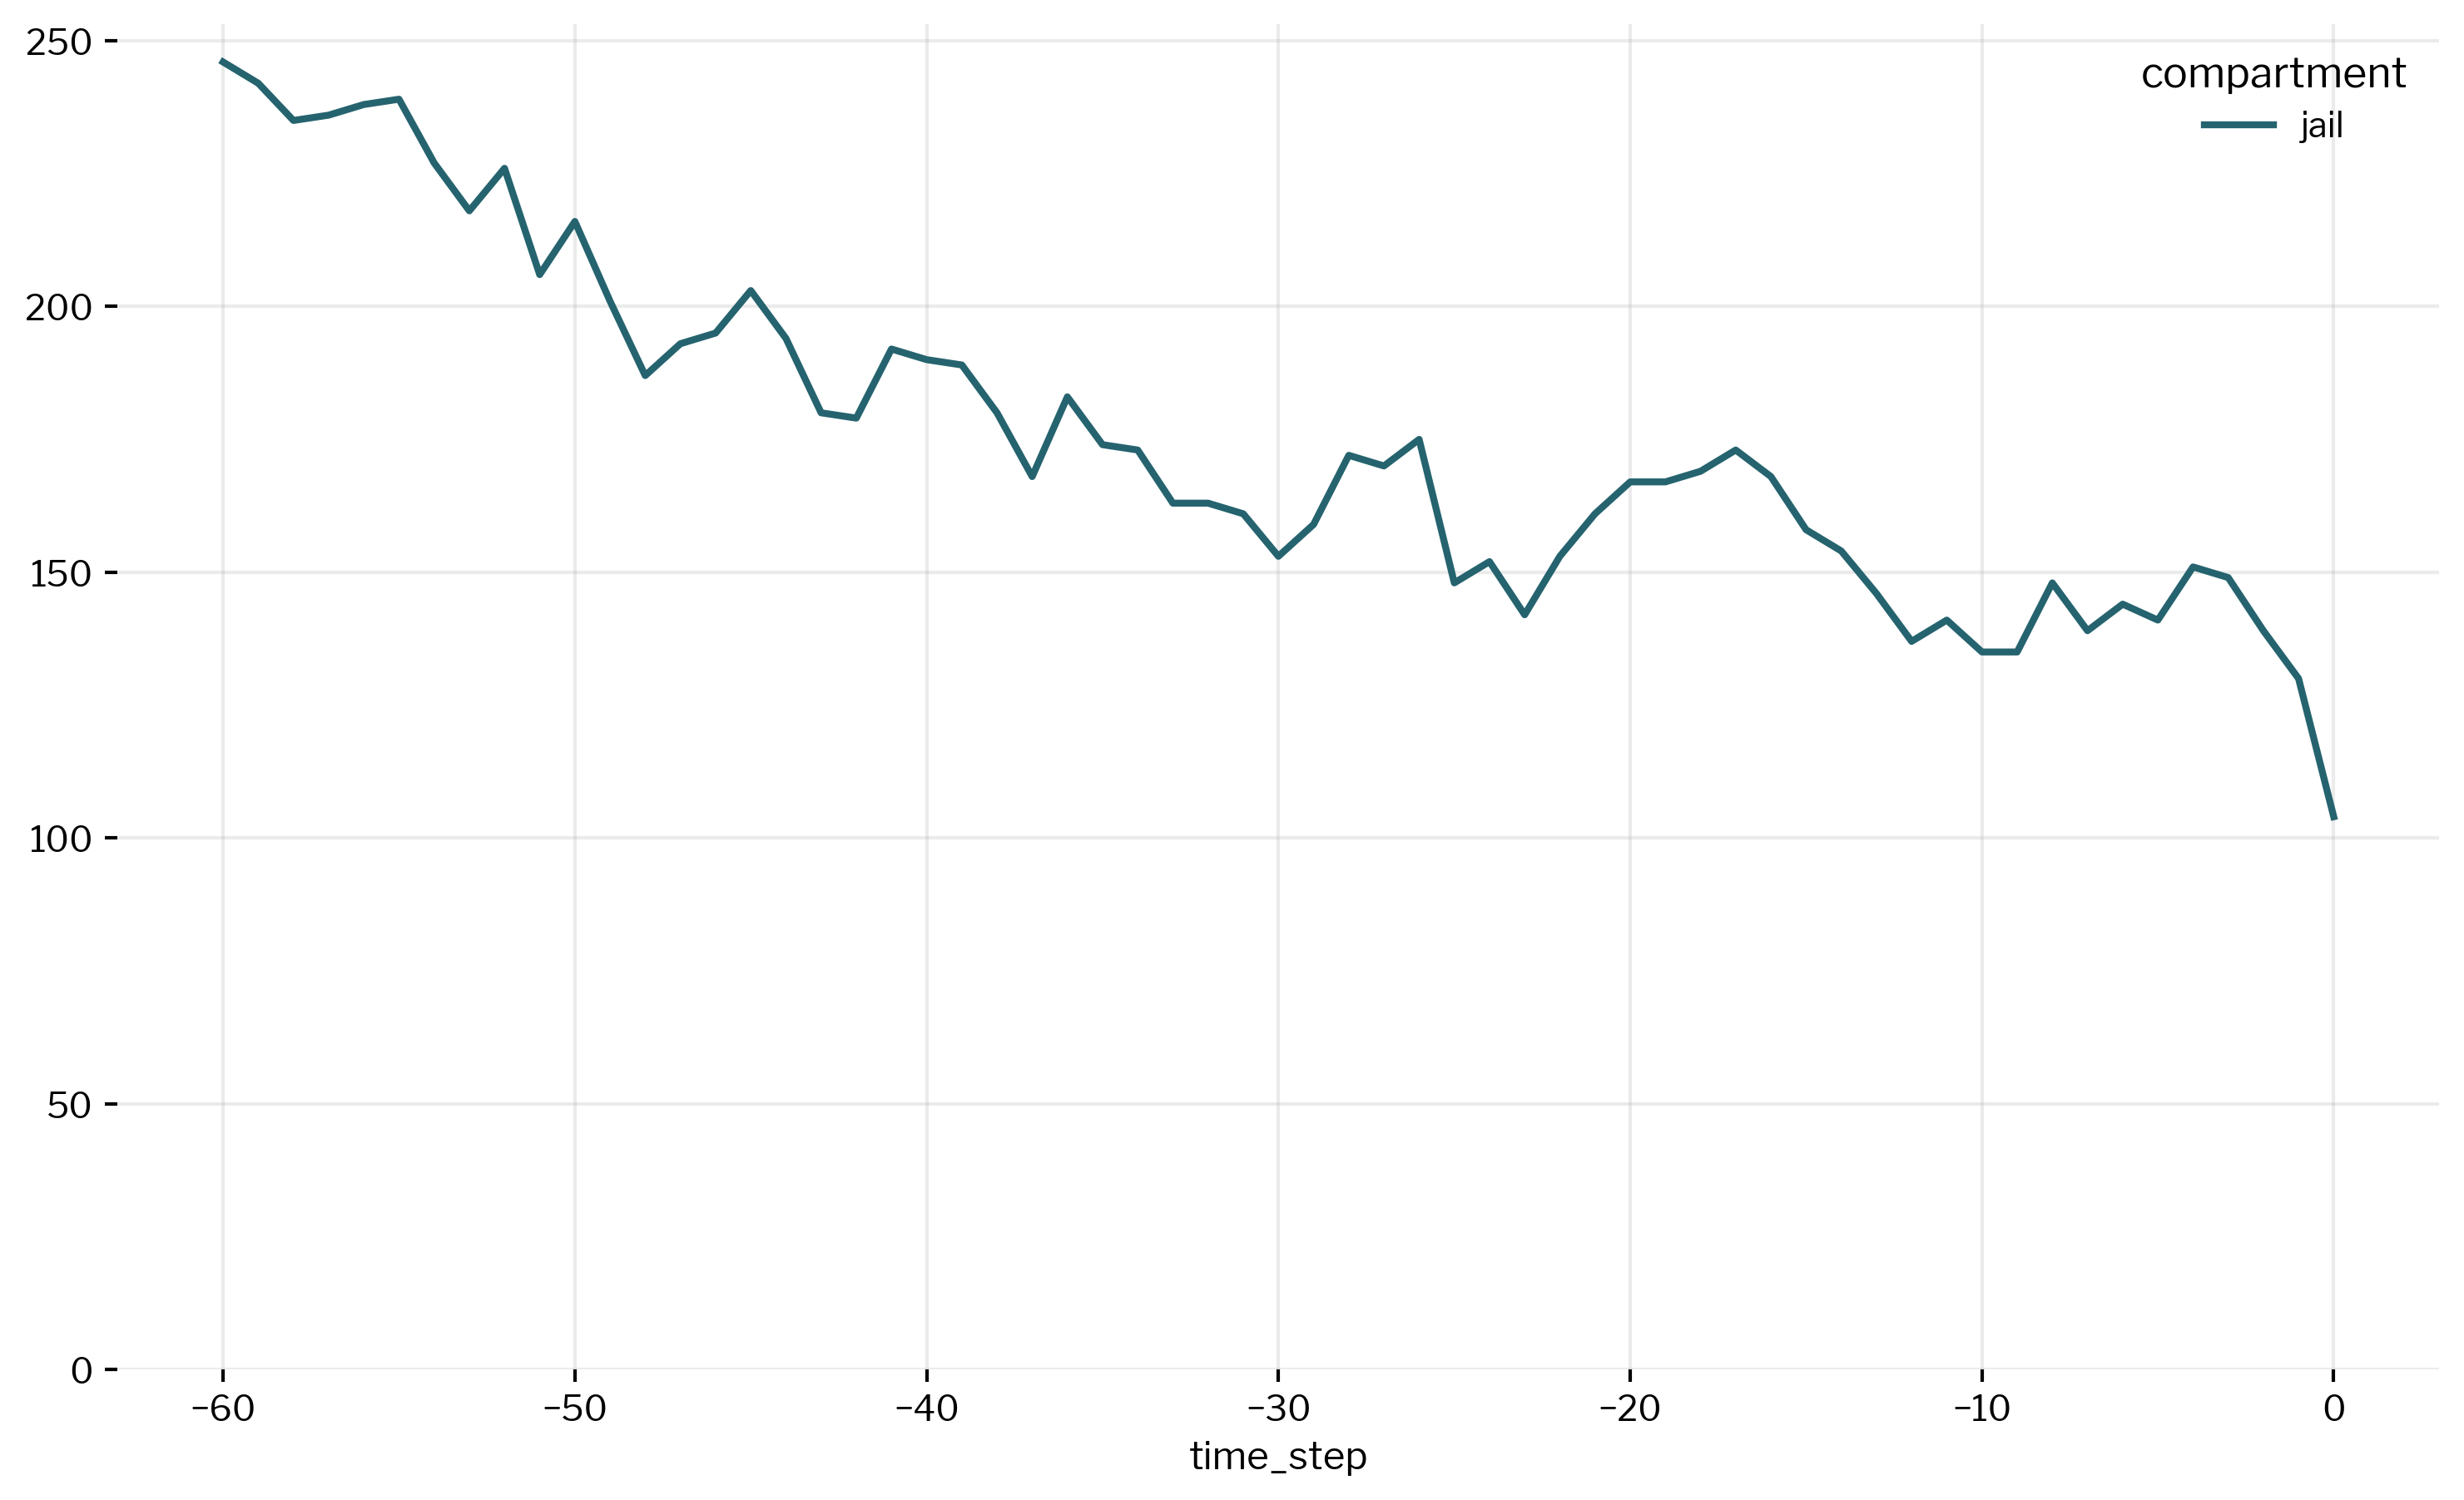

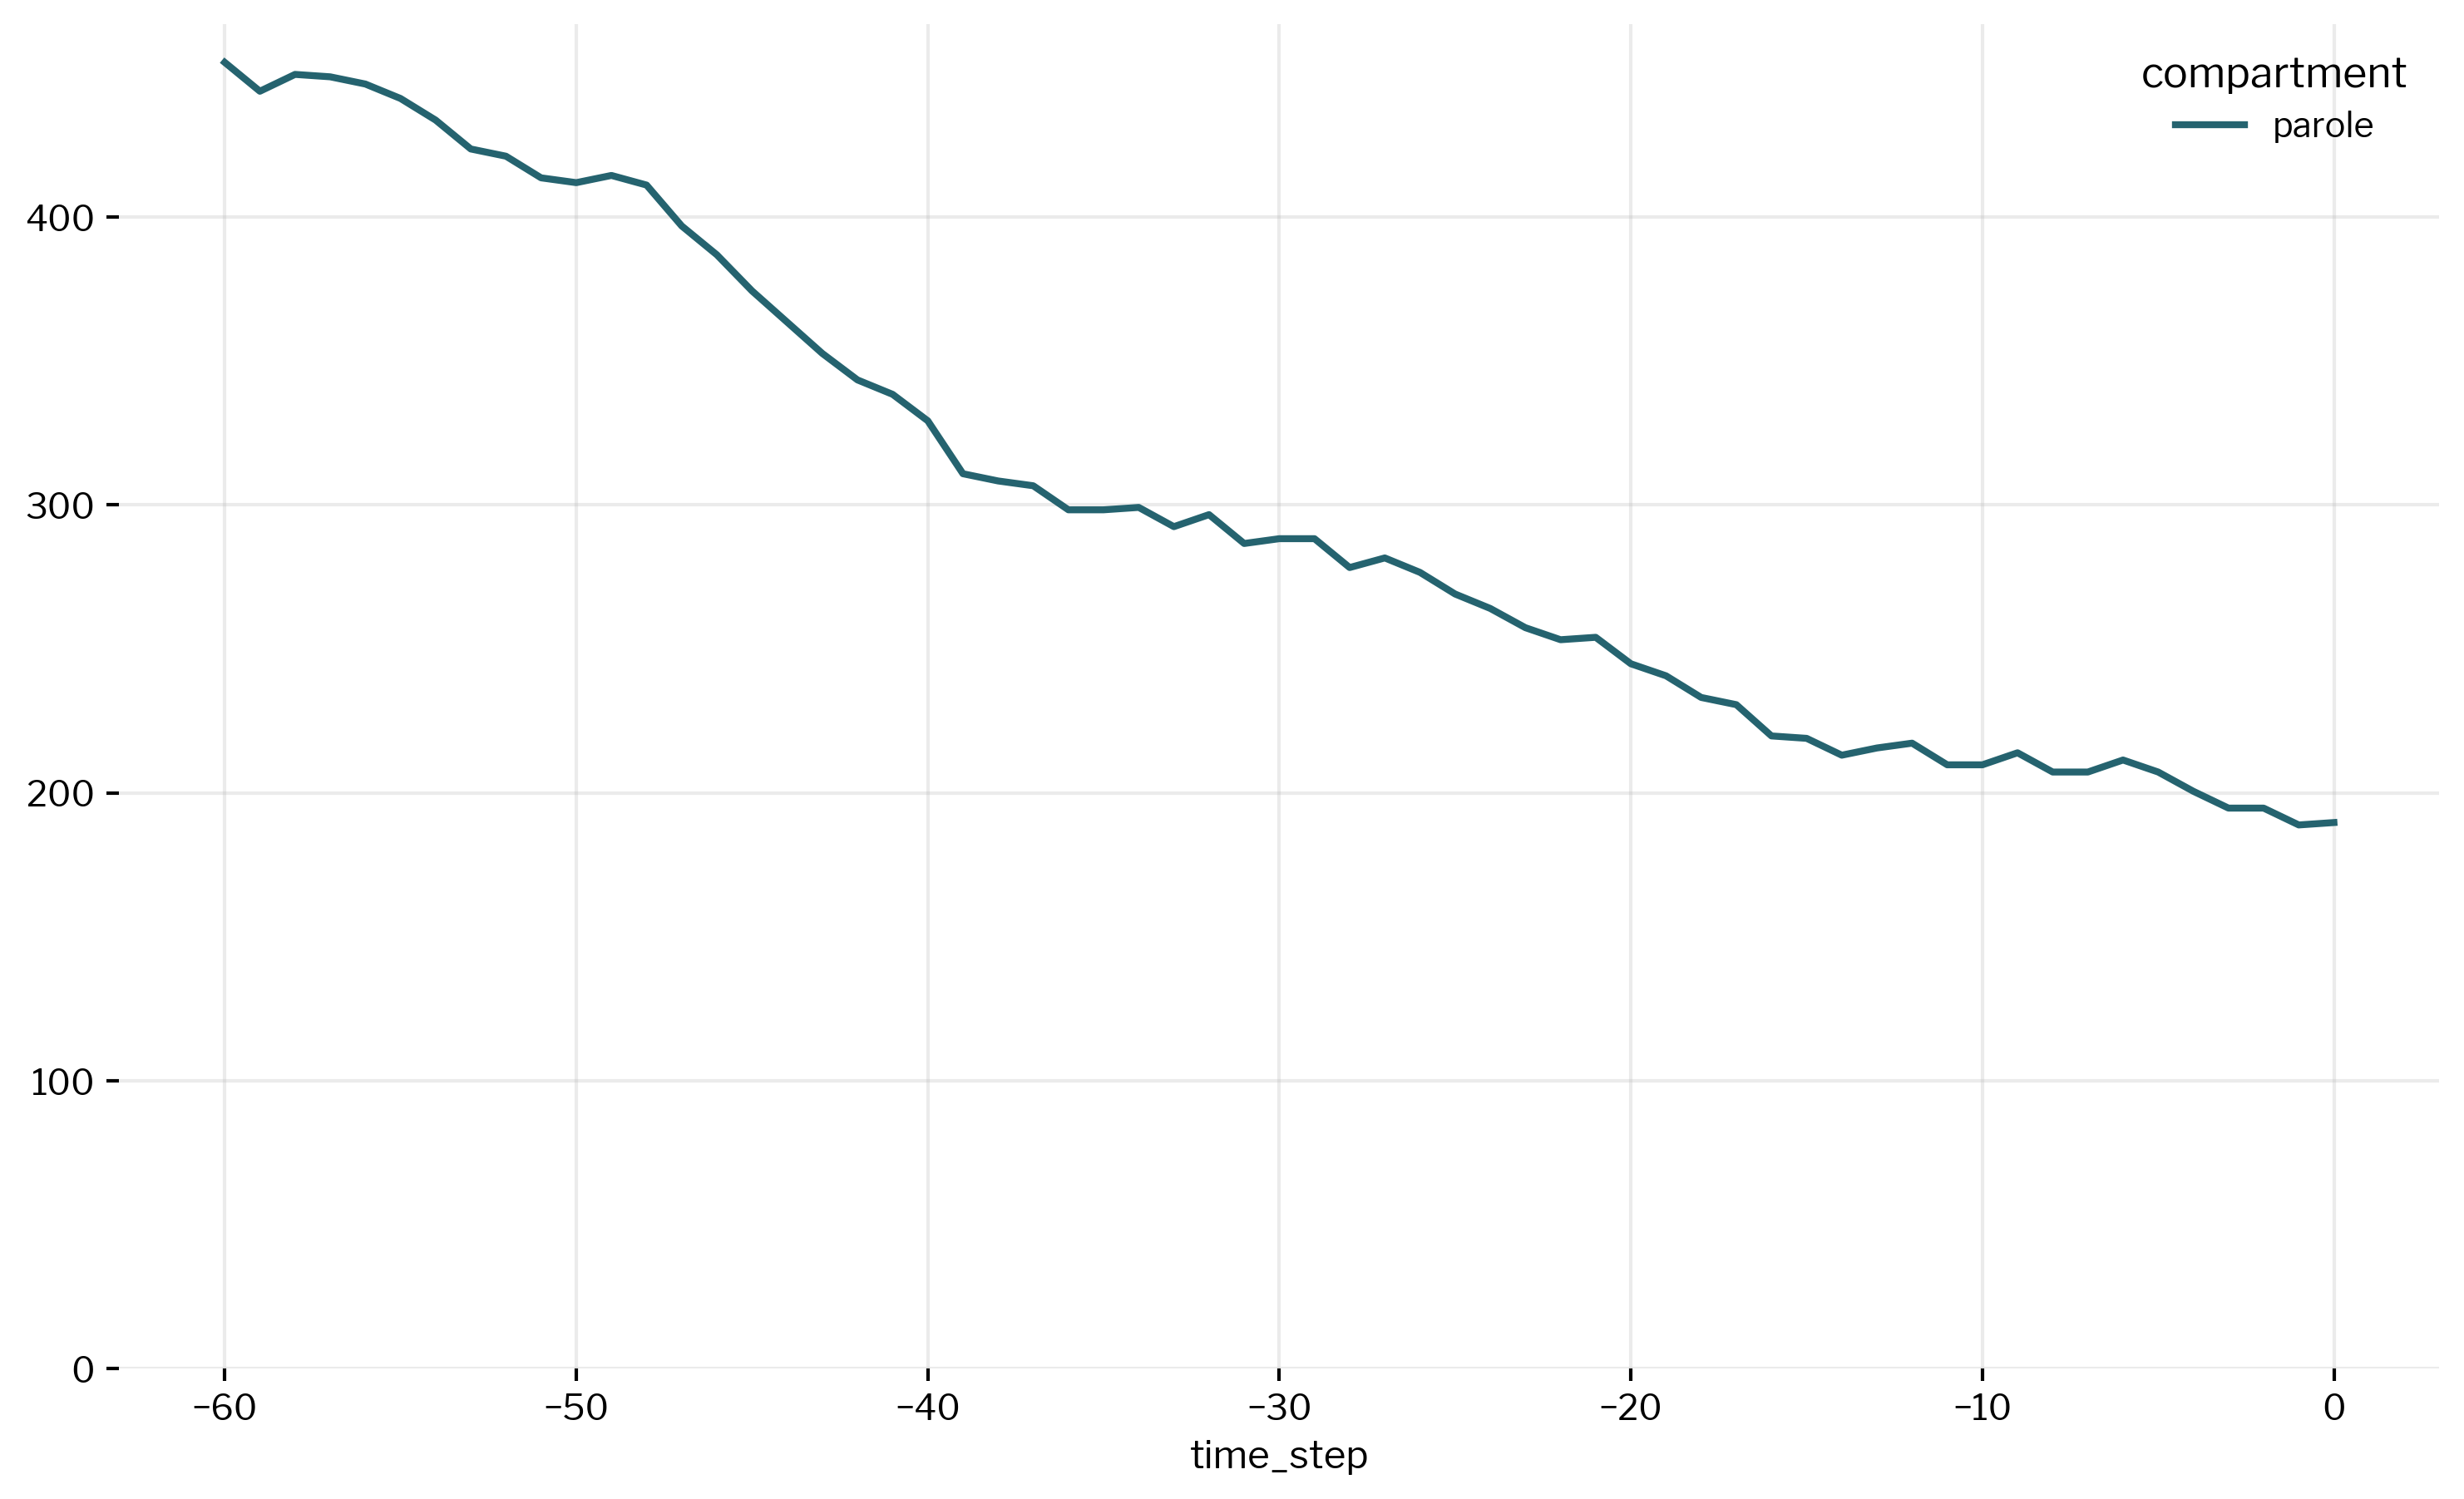

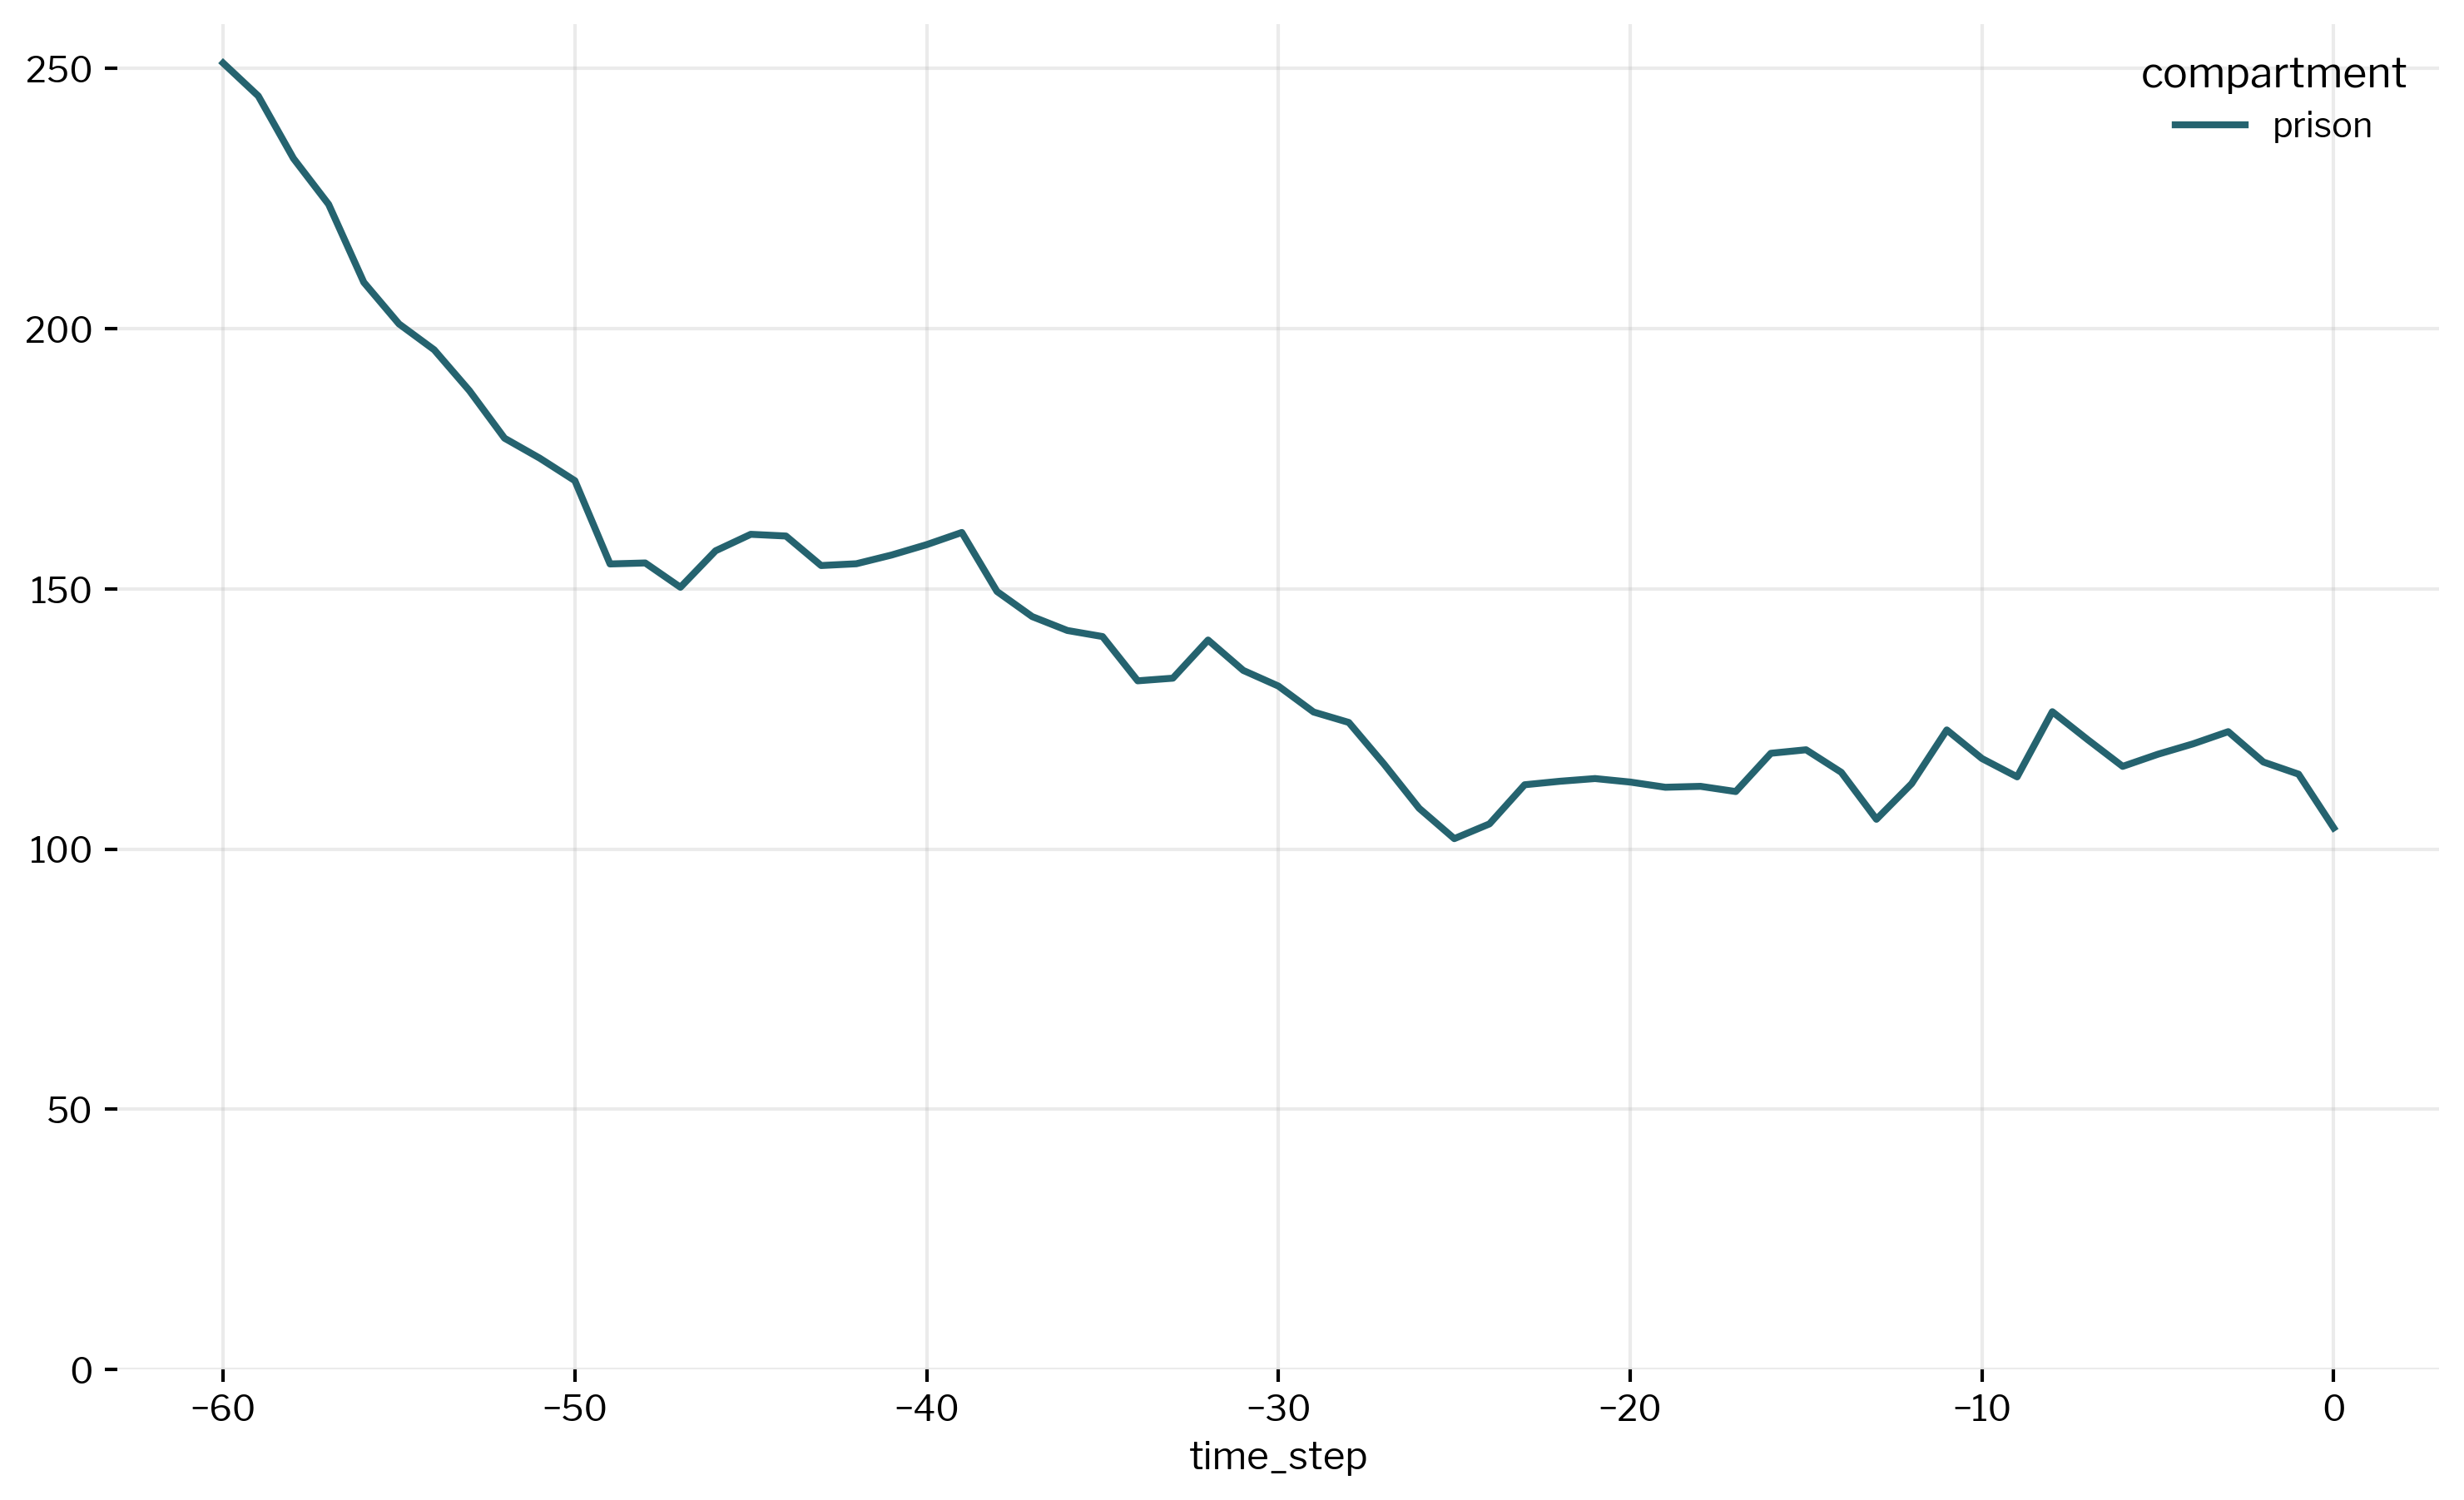

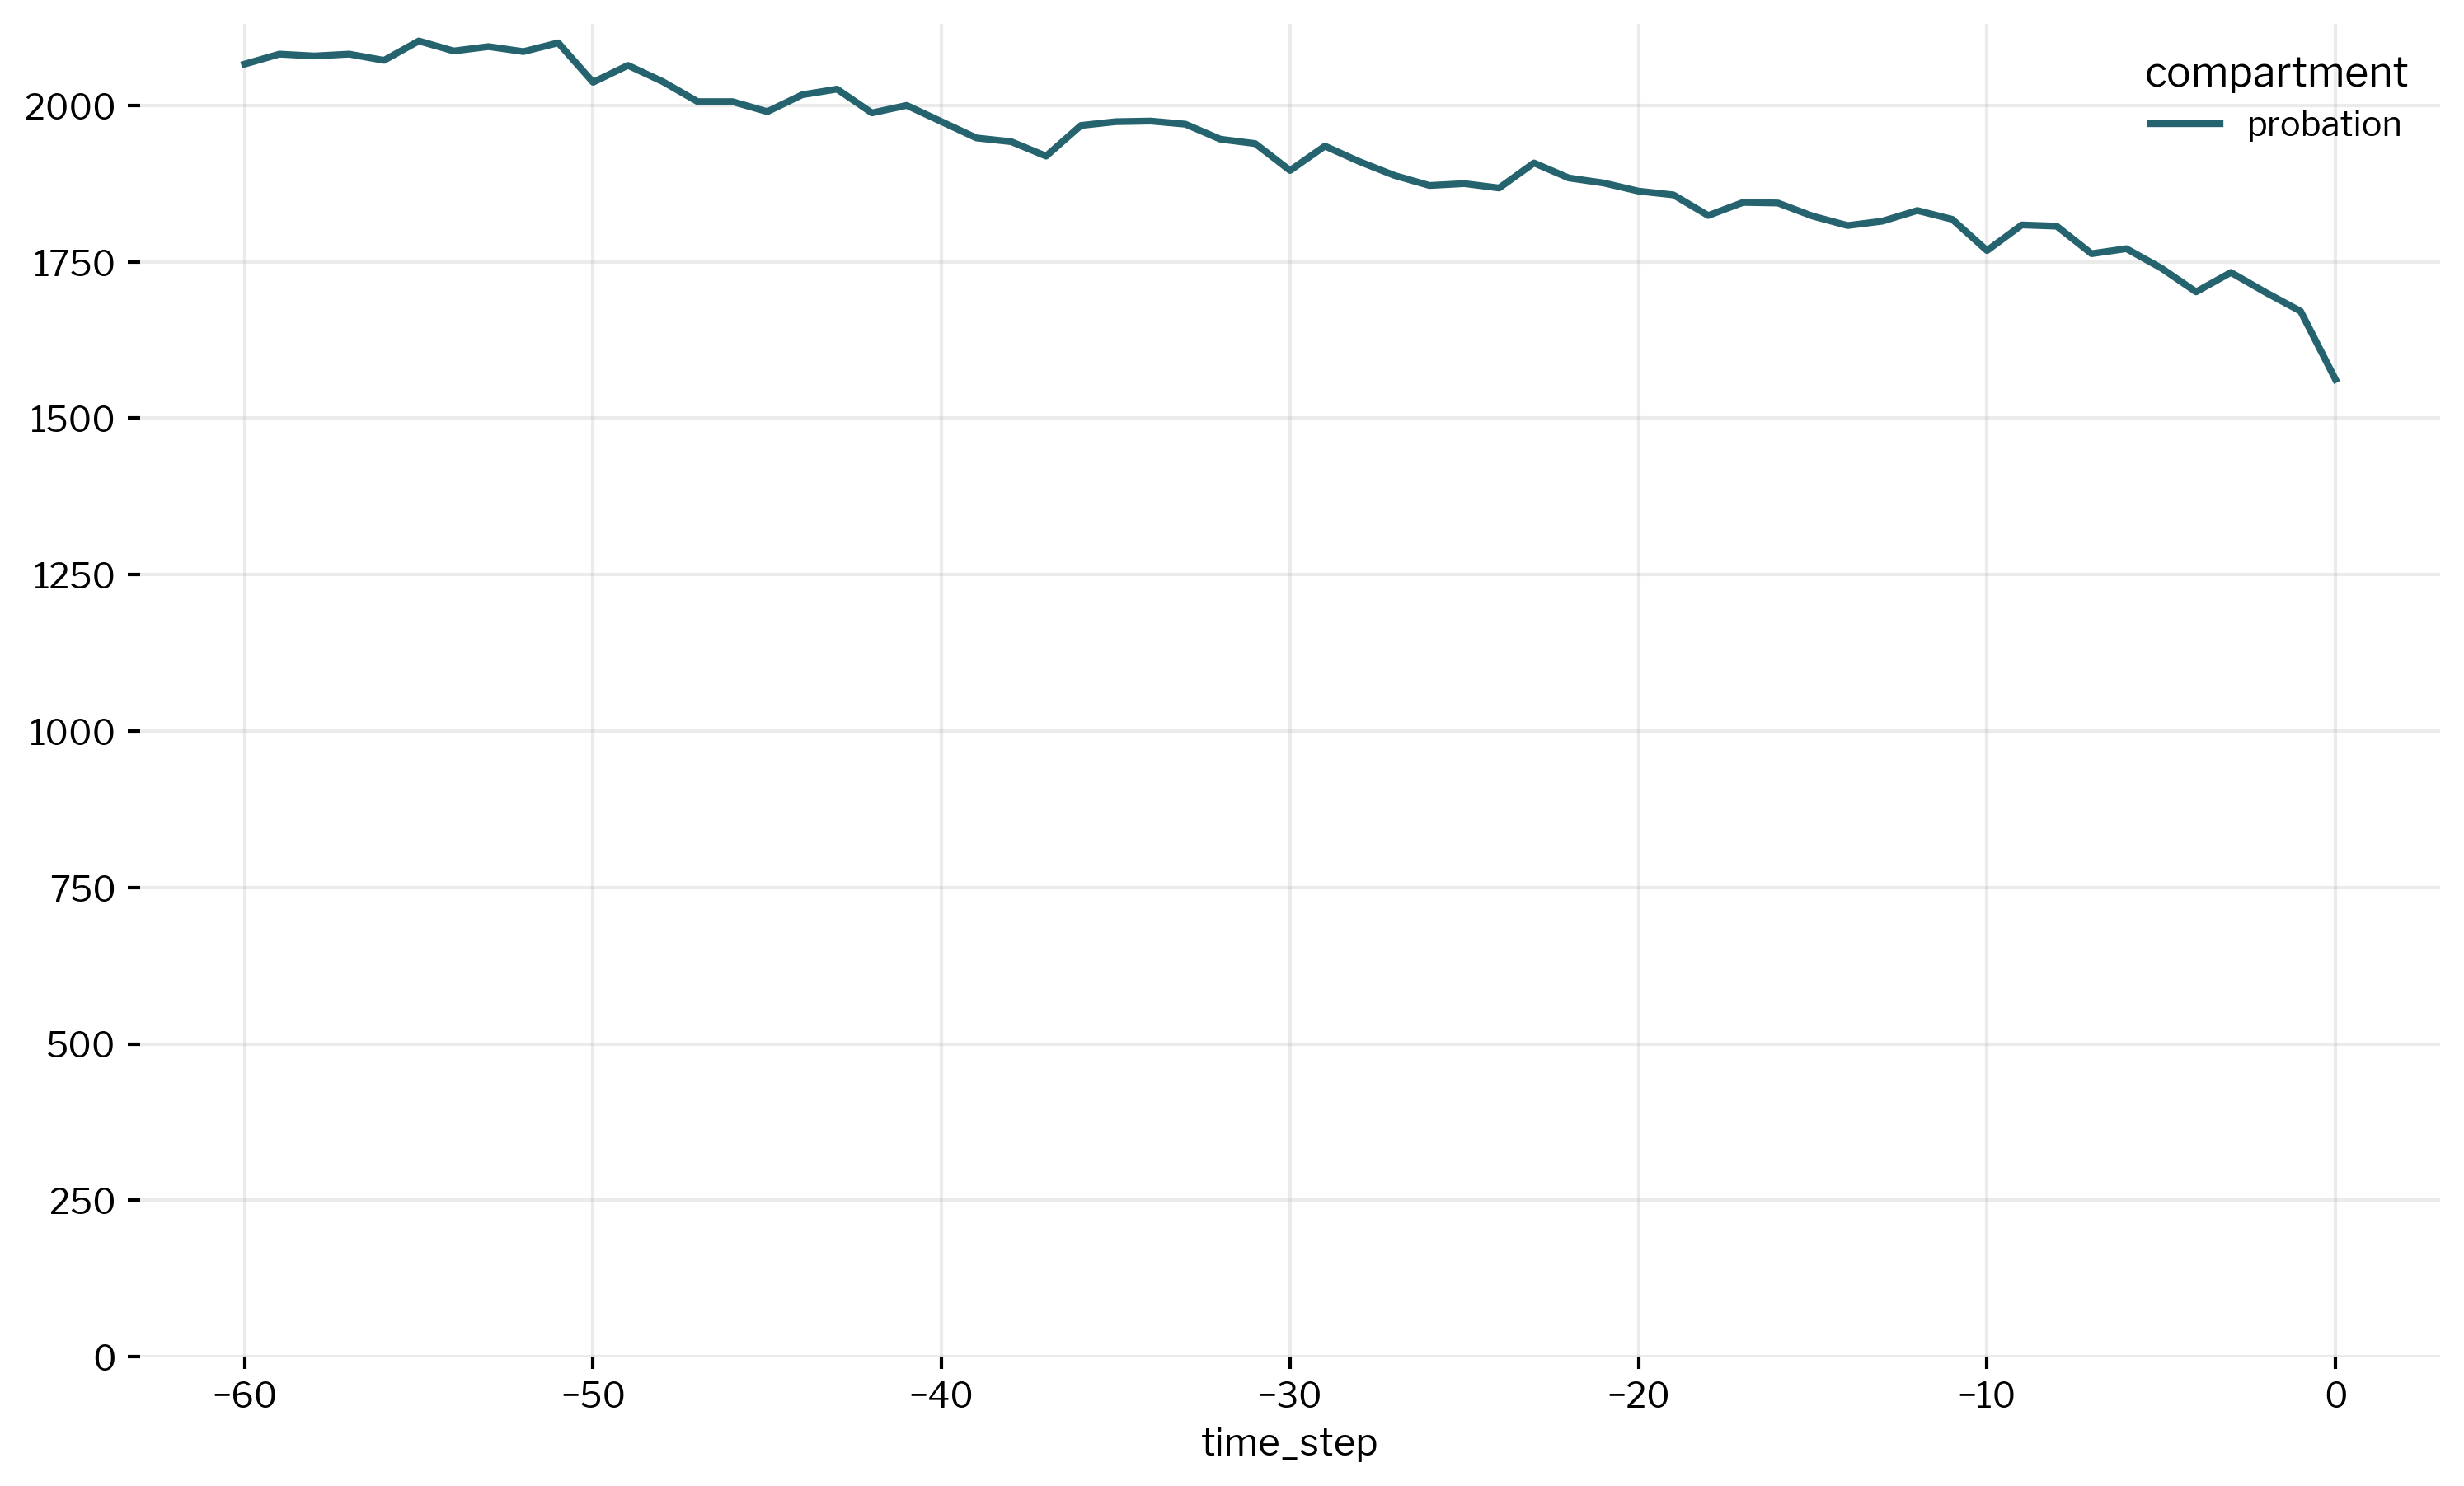

In [34]:
for compartment in total_population.compartment.unique():
    total_population.groupby(["time_step", "compartment"])[
        ["total_population"]
    ].sum().reset_index().pivot(
        index="time_step",
        columns="compartment",
        values="total_population",
    )[
        [compartment]
    ].plot()
    plt.ylim(0)

## Outflows

In [35]:
# truncate start date to month intervals
max_eligible_mj_sentences_with_month = max_eligible_mj_sentences[
    ["ID", "dos", "sentence_compartment", "start_date", "crime_type"]
].copy()
max_eligible_mj_sentences_with_month[
    "month"
] = max_eligible_mj_sentences_with_month.start_date.dt.to_period("M").dt.to_timestamp()
max_eligible_mj_sentences_with_month[
    ["dos", "sentence_compartment", "start_date", "crime_type", "month"]
].head()

,dos,sentence_compartment,start_date,crime_type,month
42926,2016-02-17,probation,2016-02-17,any,2016-02-01
102175,2019-08-01,probation,2019-08-01,only,2019-08-01
328482,2017-08-08,probation,2017-08-08,only,2017-08-01
143049,2010-03-11,jail,2010-03-11,only,2010-03-01
17705,2018-05-16,jail,2018-05-16,only,2018-05-01


In [36]:
# group
monthly_admissions_data = (
    max_eligible_mj_sentences_with_month[
        max_eligible_mj_sentences_with_month.month < "2020-01-01"
    ]
    .groupby(["crime_type", "sentence_compartment", "month"])[["ID"]]
    .nunique()
    .rename(columns={"ID": "admissions"})
)
monthly_admissions_data["compartment"] = "pretrial"
monthly_admissions_data.rename(
    columns={"sentence_compartment": "outflow_to"}, inplace=True
)

In [37]:
# # df. index get level values
# df = monthly_admissions_data.copy()
# df[(df.index.get_level_values('crime_type')=='any') & (df.index.get_level_values('sentence_compartment')=='jail')]

In [38]:
# for each crime_type [any, only] and compartment [prison, etc.]
outflows = pd.DataFrame()
for group, group_monthly_admissions in monthly_admissions_data.groupby(level=[0, 1]):

    # merge PA mj arrest data through 2022-10-01
    admissions_with_arrests = pd.merge(
        group_monthly_admissions.reset_index([0, 1]),
        monthly_pa_mj_arrest_data,
        how="outer",
        left_index=True,
        right_index=True,
    )
    admissions_with_arrests[
        ["crime_type", "sentence_compartment", "compartment"]
    ] = admissions_with_arrests[
        ["crime_type", "sentence_compartment", "compartment"]
    ].fillna(
        method="ffill"
    )

    # count up arrests and admissions for months where we have data for both
    # 2017-01-01 thru 2019-12-01
    # calculate average rate of arrest->admission rate
    admissions_with_arrests["avg_arrest_to_admission_rate"] = (
        admissions_with_arrests[
            admissions_with_arrests.admissions.notnull()
            & admissions_with_arrests.avg_arrests_per_month.notnull()
        ].admissions.sum()
        / admissions_with_arrests[
            admissions_with_arrests.admissions.notnull()
            & admissions_with_arrests.avg_arrests_per_month.notnull()
        ].avg_arrests_per_month.sum()
    )
    # Calculate projected prison admissions thru 2022 based on average arrest->incarceration ratio for 2017-2019
    admissions_with_arrests["calc_admissions_by_month"] = (
        admissions_with_arrests.avg_arrests_per_month
        * admissions_with_arrests.avg_arrest_to_admission_rate
    )

    # combine historical admission data pre-2020 and projected admissions 2020 onwards
    admissions_with_arrests[
        "total_population"
    ] = admissions_with_arrests.admissions.astype("float64").combine_first(
        admissions_with_arrests.calc_admissions_by_month
    )

    # add to full outflows table
    outflows = pd.concat([outflows, admissions_with_arrests])

outflows.index = convert_dates(time_converter, outflows.reset_index()["index"].dt.date)
outflows = outflows.reset_index()
outflows = outflows[
    ["index", "crime_type", "sentence_compartment", "total_population"]
].copy()
outflows["compartment"] = "pretrial"
outflows = outflows.rename(
    columns={"index": "time_step", "sentence_compartment": "outflow_to"}
)
outflows = outflows[outflows.time_step >= -60]

<AxesSubplot: xlabel='time_step'>

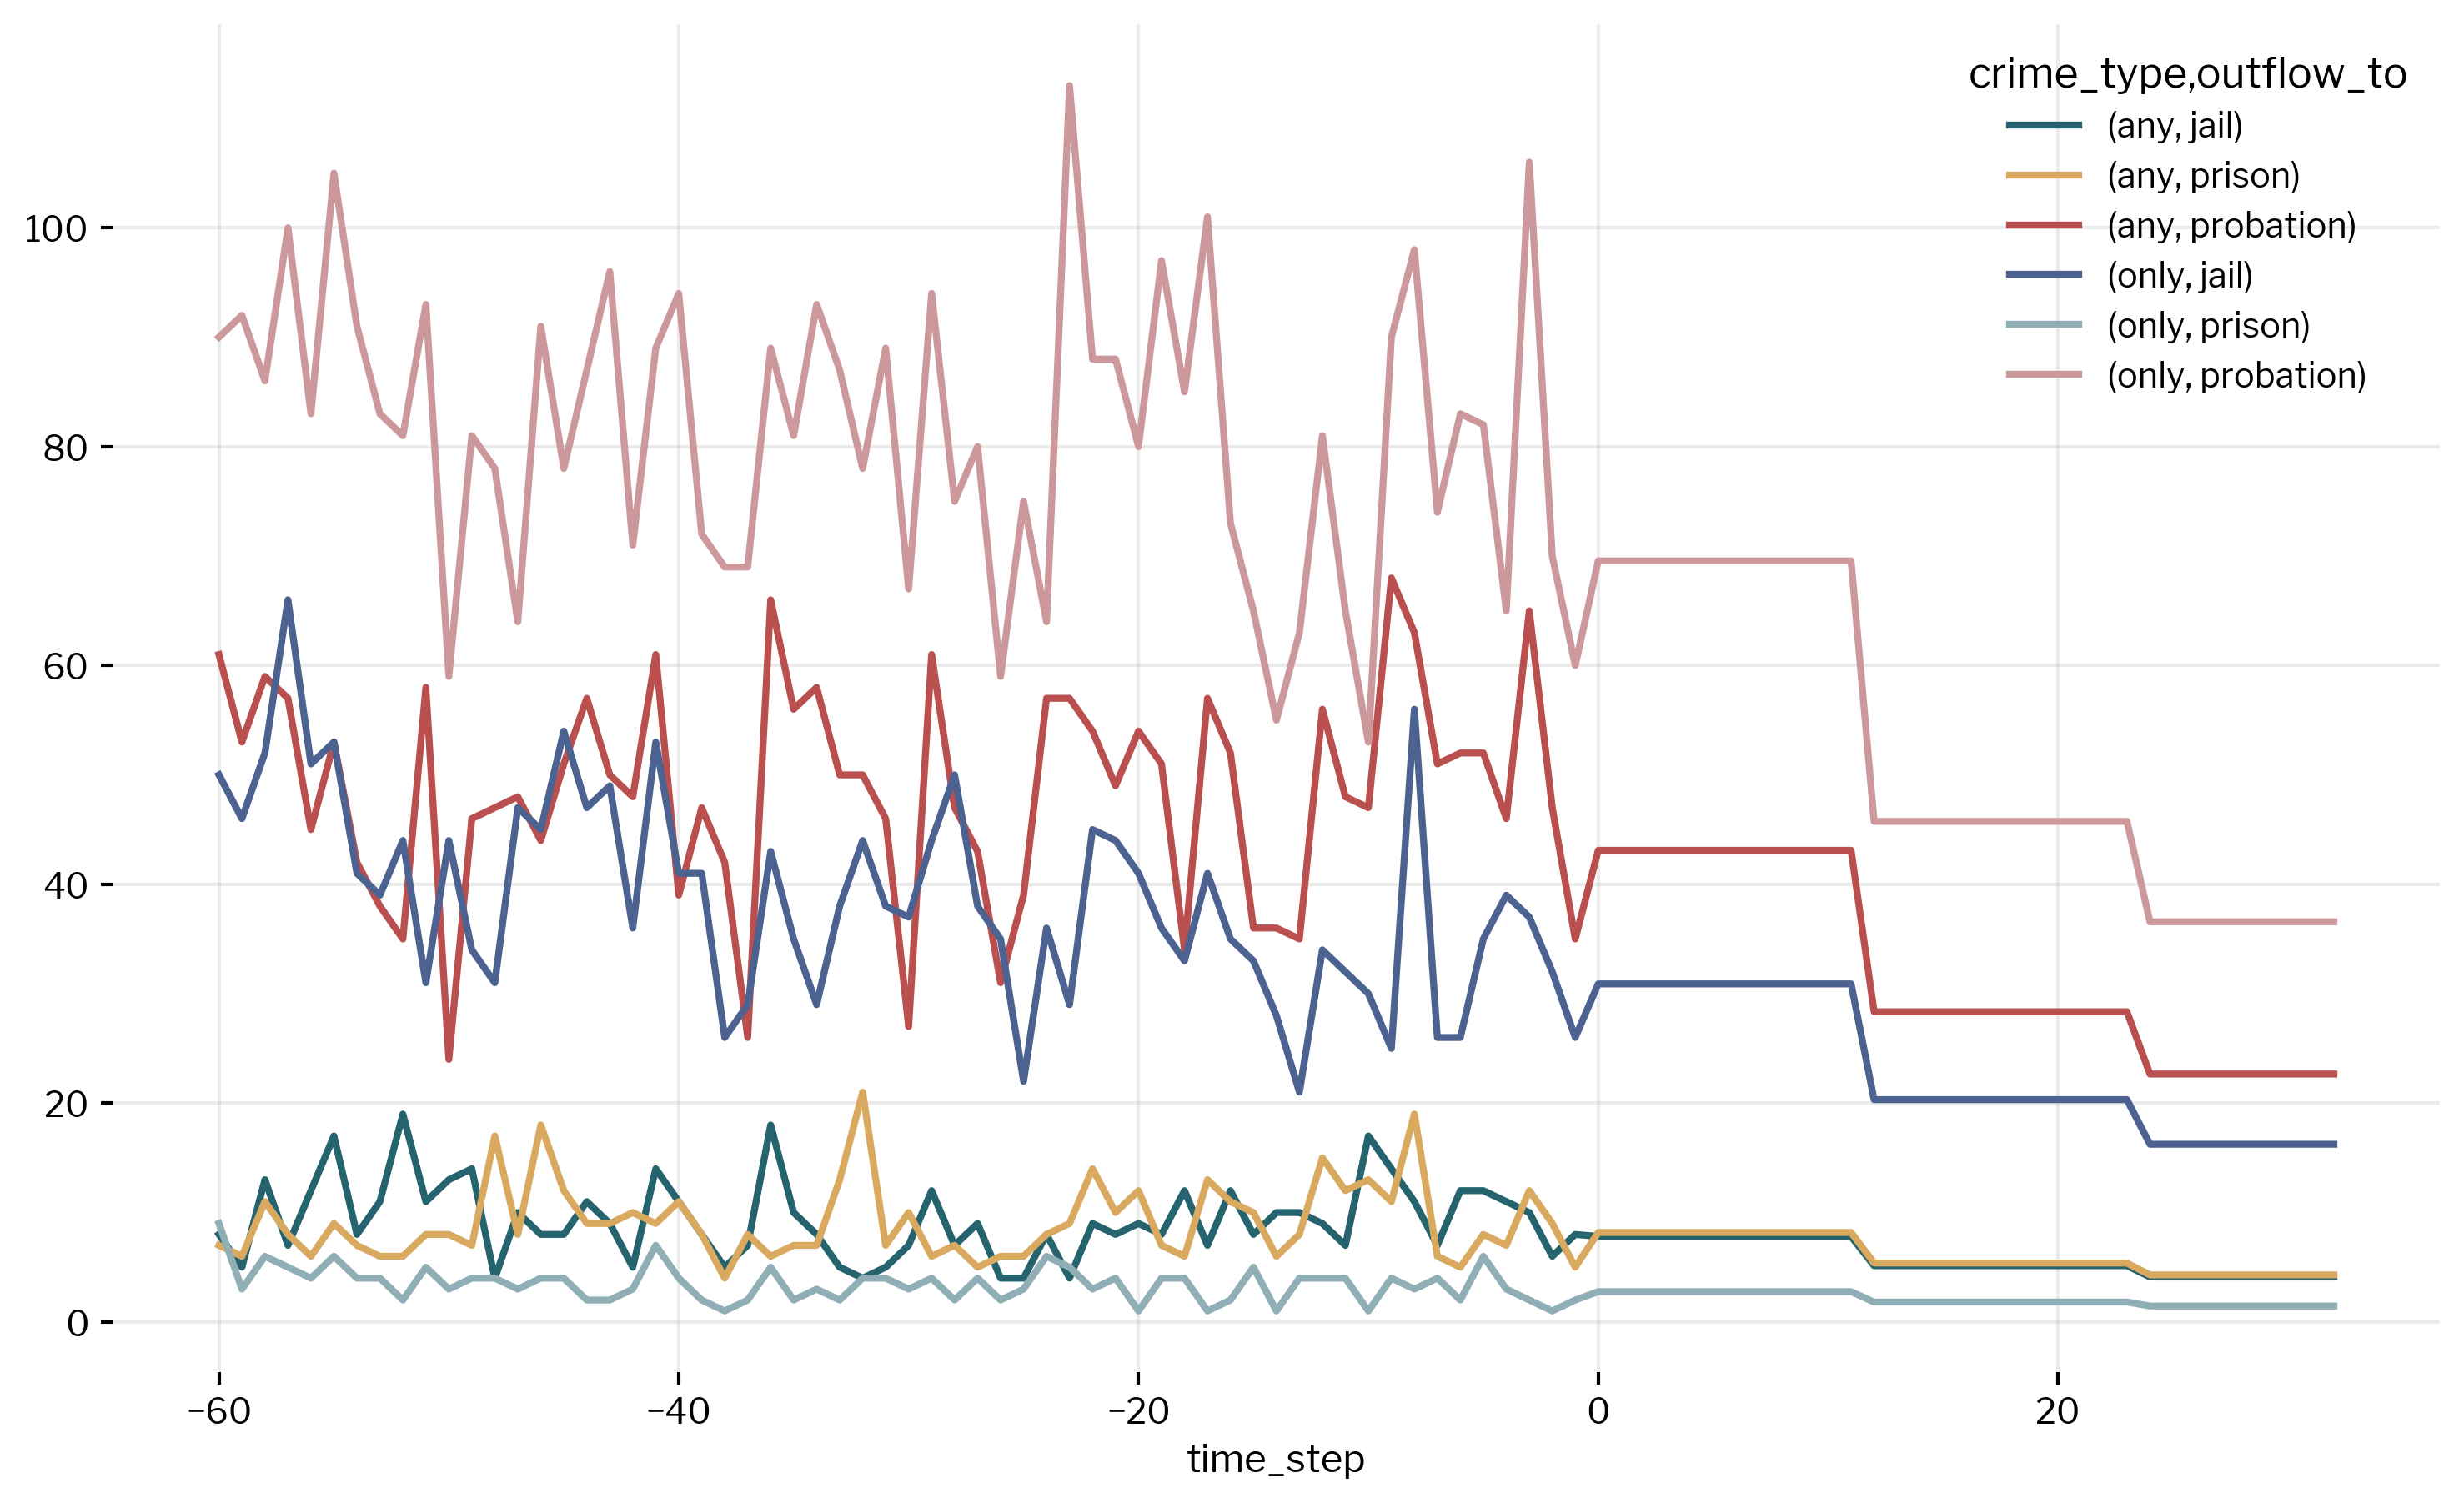

In [39]:
outflows.pivot(
    index="time_step", columns=["crime_type", "outflow_to"], values="total_population"
).plot()

In [40]:
outflows[outflows.outflow_to == "jail"]

,time_step,crime_type,outflow_to,total_population,compartment
60,-60,any,jail,8.000000,pretrial
61,-59,any,jail,5.000000,pretrial
62,-58,any,jail,13.000000,pretrial
63,-57,any,jail,7.000000,pretrial
64,-56,any,jail,12.000000,pretrial
65,-55,any,jail,17.000000,pretrial
66,-54,any,jail,8.000000,pretrial
67,-53,any,jail,11.000000,pretrial
68,-52,any,jail,19.000000,pretrial
69,-51,any,jail,11.000000,pretrial


In [41]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=outflows,
    transitions_data_df=transitions,
    total_population_data_df=total_population,
    yaml_path=yaml_file_path,
)

100%|███████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]
